In [1]:
import dynamiqs as dq
from dynamiqs.result import SolveResult
from dynamiqs import TimeQArray
from dynamiqs.time_qarray import ConstantTimeQArray, SummedTimeQArray

from jax import Array, vmap, jit
from jax.lax import cond, scan
import jax.numpy as jnp
from jax.random import PRNGKey, uniform

from functools import reduce

from time import time
import matplotlib.pyplot as plt

dq.set_precision('double')

In [2]:
a  = dq.destroy(10) & dq.eye(2)
sm = dq.eye(10)     & dq.sigmam()
sz = dq.eye(10)     & dq.sigmaz()

H0 = a.dag() @ a @ sz
H1s = [
    a     + dq.hc,
    1j*a  + dq.hc,
    sm    + dq.hc,
    1j*sm + dq.hc,
]

tlist = jnp.linspace(0., 1., 100)
def H_func(params):
    H=dq.constant(H0)
    H+=dq.pwc(tlist, params[0, :], H1s[0])
    H+=dq.pwc(tlist, params[1, :], H1s[1])
    H+=dq.pwc(tlist, params[2, :], H1s[2])
    H+=dq.pwc(tlist, params[3, :], H1s[3])
    return H

In [3]:
def evaluate_controls0(tsave: Array, H: TimeQArray) -> Array:

    def _evaluate_at_tsave(_H: TimeQArray) -> Array:
        if not isinstance(_H, ConstantTimeQArray):
            return jnp.sum(vmap(_H.prefactor)(tsave))
        return jnp.array(0.0)

    if isinstance(H, SummedTimeQArray):
        control_val = 0.0
        for _H in H.timeqarrays:
            control_val += _evaluate_at_tsave(_H)
    else:
        control_val = _evaluate_at_tsave(H)

    return jnp.abs(control_val)

def evaluate_controls1(tsave: Array, H: TimeQArray) -> Array:

    def _evaluate_at_tsave(_H: TimeQArray) -> Array:
        return cond(
            isinstance(_H, ConstantTimeQArray),
            lambda _ : jnp.array(0.0),
            lambda _ : jnp.sum(_H.prefactor(tsave)).astype(float),
            None,
        )

    if isinstance(H, SummedTimeQArray):
        control_val = 0.0
        for _H in H.timeqarrays:
            control_val += _evaluate_at_tsave(_H)
    else:
        control_val = _evaluate_at_tsave(H)

    return jnp.abs(control_val)

def evaluate_controls2(tsave: Array, H: TimeQArray) -> Array:

    def _evaluate_at_tsave(_H: TimeQArray) -> Array:
        if not isinstance(_H, ConstantTimeQArray):
            return jnp.sum(vmap(_H.prefactor)(tsave))
        return jnp.array(0.0)

    if isinstance(H, SummedTimeQArray):
        control_val = reduce(lambda x, y: x + _evaluate_at_tsave(y),
                             H.timeqarrays,
                             0.0,
                            )
    else:
        control_val = _evaluate_at_tsave(H)

    return jnp.abs(control_val)

def evaluate_controls3(tsave: Array, H: TimeQArray) -> Array:
    def _evaluate_at_tsave(_H: TimeQArray) -> Array:
        return cond(
            isinstance(_H, ConstantTimeQArray),
            lambda _ : jnp.array(0.0),
            lambda _ : jnp.sum(_H.prefactor(tsave)).astype(float),
            None,
        )

    if isinstance(H, SummedTimeQArray):
        control_val = reduce(lambda x, y: x + _evaluate_at_tsave(y),
                             H.timeqarrays,
                             0.0,
                            )
    else:
        control_val = _evaluate_at_tsave(H)

    return jnp.abs(control_val)

In [4]:
param_shape = (len(H1s), len(tlist)-1)

funcs = [evaluate_controls0, evaluate_controls1, evaluate_controls2, evaluate_controls3]
funcs += [jit(f) for f in funcs]

times = [[], [], [], [], [], [], [], []]
assert len(times) == len(funcs)

for idx, f in enumerate(funcs):
    for r in range(100):
        key = PRNGKey(r)
        parameters = uniform(key, param_shape, minval=-1.0, maxval=1.0)
        H = H_func(parameters)

        solution = jnp.abs(jnp.sum(parameters))
    
        start_time = time()
        sol = f(tlist, H)
        times[idx].append(time() - start_time)
        assert jnp.allclose(solution, sol, atol=1e-8), f"failed at {r}: {solution} != {sol}"

Text(0.5, 0, 'Iteration')

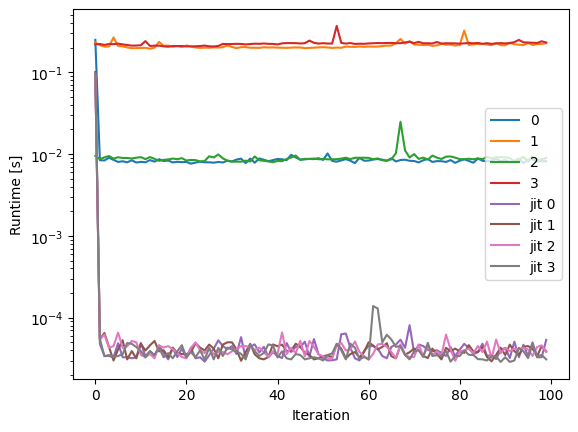

In [6]:
labels =  [f'{i}' for i in range(len(funcs)//2)]
labels += [f'jit {i}' for i in range(len(funcs)//2)]

for t,l in zip(times, labels):
    plt.plot(t, label=l)
plt.yscale('log')
plt.legend()
plt.ylabel('Runtime [s]')
plt.xlabel('Iteration')

## Conclusion
Functions 
- 0 = Pythonic function with `if` and `for` 
- 1 = `if` changed to `cond`
- 2 = `for` changed to `functools.reduce`
- 3 = both `if` and `for` changed

Takeaways:
- The normal pythonic function is faster than any forced optimizations.
- Slow down comes from changing `if` to `cond`.
- `jit`ing all the functions results in the same runtime. Might as well use the readable pythonic version.

Note:
- I tried to use `vmap` to compute the prefactors for all H's in parallel. 
- However, this failed because the Hs are `TimeQarrays`; not normal `Arrays`. As a result, `jax` found multiple arrays within the TimeQArray, and was confused on what axis to parallelize over. 
- Same problem when I tried to use `scan` to iterate through the Hs. 